In [1]:
import os
import itertools
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm import tqdm

In [2]:
HERE = os.getcwd()

PATH_EMBEDDINGS = os.path.join(HERE, *["..", "cavaface", "eval"])
PATH_DEBUG = os.path.join(HERE, *["..", "debug"])
PATH_FIGURES = os.path.join(HERE, "figures")
os.makedirs(PATH_FIGURES, exist_ok=True)

all_csvs = glob(os.path.join(PATH_EMBEDDINGS, "*.csv"))

models = dict()
for path in all_csvs:
    _, fname = os.path.split(path)
    if "classes" in fname:
        model = fname.split("classes_")[1][:-4]
        pathtype = "class"
    elif "emb" in fname:
        model = fname.split("emb_")[1][:-4]
        pathtype = "embedding"
    else:
        continue
    if model not in models:
        models[model] = dict()
        
    models[model][f"path_{pathtype}"] = path
    
print("Available models:")
print("\t"+"\n\t".join(models.keys()))

Available models:
	highres144_in_highlow_144
	highres144_in_highres_144
	highres144_in_lowres144
	highres32_in_highlow_144
	highres32_in_highres_144
	highres32_in_lowres144
	highres32_in_lowres32


In [3]:
def load(model):
    path_class = models[model]["path_class"]
    path_embs = models[model]["path_embedding"]
    embs = np.genfromtxt(path_embs, delimiter=",")
    clss = np.genfromtxt(path_class, delimiter=",", dtype=int)
    
#     print(embs.shape)
#     print(clss.shape)
    
    return clss, embs

In [4]:
for model in tqdm(models.keys()):
    if "clss" not in models[model]:
        clss, embs = load(model)
        models[model]["clss"] = clss
        models[model]["embs"] = embs

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:12<00:00,  1.72s/it]


# Embedding analysis

In [5]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances
from pycpd import RigidRegistration, DeformableRegistration, AffineRegistration
from functools import partial

## PCA on embeddings

In [6]:
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

def get_PCA3(model):  
    embs = models[model]["embs"]

    pca = PCA(n_components=3)
    pca3 = pca.fit_transform(embs)
    
    return pca3

def plot_PCA(model, clss, pca3, n=400):
    assert n <= len(clss)//4
    
    # SEPARATE PCA
    fig = plt.figure()
    fig.set_tight_layout(True)
    ax = fig.add_subplot(111, projection='3d')
    
    clss_toplot = list(np.random.choice(np.arange(len(clss)//4), size=n, replace=False))
    idx_toplot = []
    cat_toplot = []
    for c in clss_toplot:
        idx_toplot += [4*c, 4*c+1, 4*c+2, 4*c+3]
        cat_toplot += [c, c, c, c]
    
    x = pca3[idx_toplot,0]
    y = pca3[idx_toplot,1]
    z = pca3[idx_toplot,2]
    
    ax.scatter(x, y, z, c=idx_toplot, cmap=cmap)
    ax.set_xlabel('X-axis', fontsize=12)
    ax.set_ylabel('Y-axis', fontsize=12)
    ax.set_zlabel('Z-axis', fontsize=12)
    
#     plt.title(f"PCA for {model} \n({n} identities shown)", fontsize=14)

    plt.tight_layout()
    
    
    plt.savefig(os.path.join(PATH_FIGURES, f"pca3-{model}-{n}.pdf"), dpi=1000)
    plt.show()

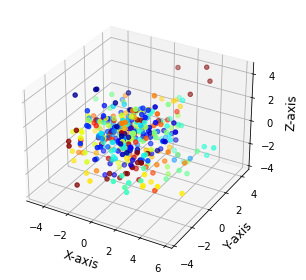

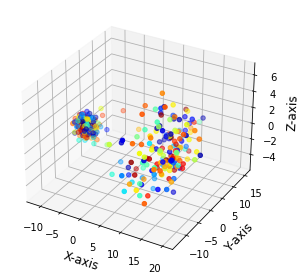

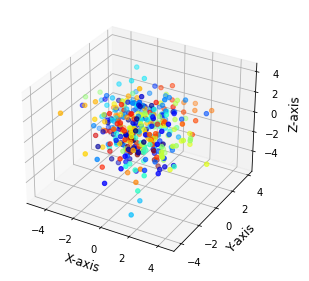

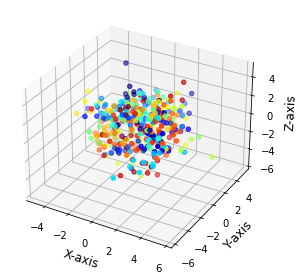

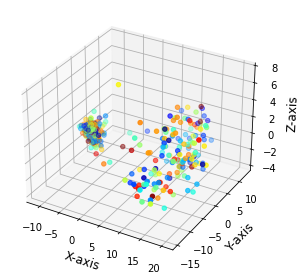

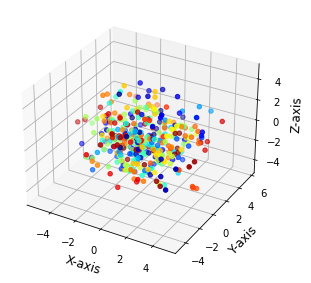

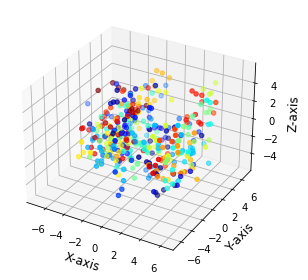

In [18]:
for model in models.keys():
    if "pca3" not in models[model]:
        pca3 = get_PCA3(model)
        models[model]["pca3"] = pca3
    else:
        pca3 = models[model]["pca3"]
    
    clss = models[model]["clss"]    
    plot_PCA(model, clss, pca3, n=100)

## PCA on embeddings for 2 models

In [29]:
from sklearn.preprocessing import normalize as sknormalize

In [34]:
def plotpca_2models(model1, model2, clss, n=400, fit_rotate=False, normalize=False):
    assert n <= len(clss)//4
    
    embs_1 = models[model1]["embs"]
    embs_2 = models[model2]["embs"]
    
    if normalize:
        embs_1 = sknormalize(embs_1, axis=1)
        embs_2 = sknormalize(embs_2, axis=1)
    
    embs_all = np.concatenate((embs_1, embs_2), axis=0)
    
    clss_toplot = list(np.random.choice(np.arange(len(clss)//4), size=n, replace=False))
    idx_toplot = []
    cat_toplot = []
    for c in clss_toplot:
        idx_toplot += [4*c, 4*c+1, 4*c+2, 4*c+3]
        cat_toplot += [c, c, c, c]
    
    pca_all = PCA(n_components=3)
    pca3 = pca_all.fit_transform(embs_all)
    
    pca3_1 = pca3[:len(embs_1), :]
    pca3_2 = pca3[len(embs_1):, :]
    
    x1 = pca3_1[idx_toplot,0]
    y1 = pca3_1[idx_toplot,1]
    z1 = pca3_1[idx_toplot,2]
    
    
    if fit_rotate:
        affine_reg = AffineRegistration(**{'X': pca3_1[idx_toplot,:], 'Y': pca3_2[idx_toplot,:]})
        affine_reg.register()
        pca3_2 = affine_reg.TY
        x2 = pca3_2[:,0]
        y2 = pca3_2[:,1]
        z2 = pca3_2[:,2]
        
    else:
        x2 = pca3_2[idx_toplot,0]
        y2 = pca3_2[idx_toplot,1]
        z2 = pca3_2[idx_toplot,2]
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    
    
    ax.scatter(x1, y1, z1, c=cat_toplot, cmap=cmap, marker='o')

    ax.scatter(x2, y2, z2, c=cat_toplot, cmap=cmap, marker='x')

    ax.set_xlabel('X-axis', fontsize=14)
    ax.set_ylabel('Y-axis', fontsize=14)
    ax.set_zlabel('Z-axis', fontsize=14)
    ax.set_rasterized(True)
    
    flag_rotate = ", Coherent Point Drift" if fit_rotate else ""
    
#     plt.title(f"PCA for {model1} vs. {model2} \n({n} identities shown{flag_rotate})", fontsize=16)

    plt.tight_layout()
    
    figname = f"pca3-{model1}-{model2}-{n}-rot.pdf" if fit_rotate else f"pca3-{model1}-{model2}-{n}.pdf"
    plt.savefig(os.path.join(PATH_FIGURES, figname), dpi=1000)
    plt.show()

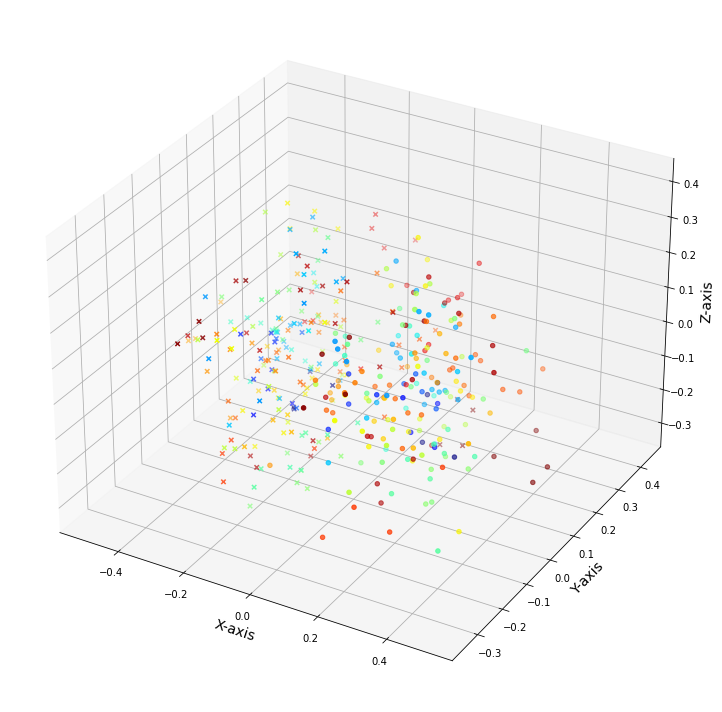

In [35]:
plotpca_2models('highres144_in_lowres144', 'highres32_in_lowres144', clss, n=50, normalize=True)

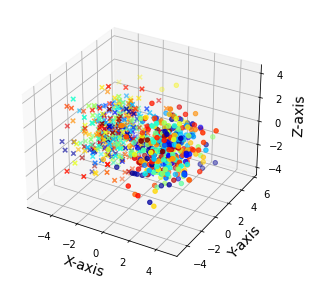

In [32]:
plotpca_2models('highres144_in_lowres144', 'highres32_in_lowres144', clss, n=100)

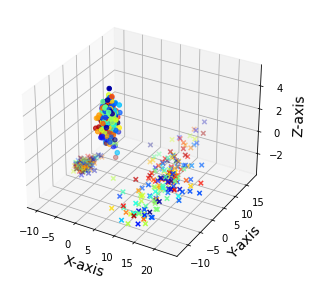

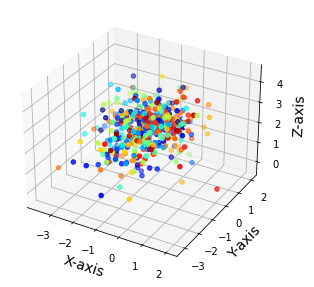

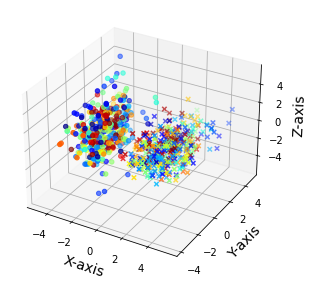

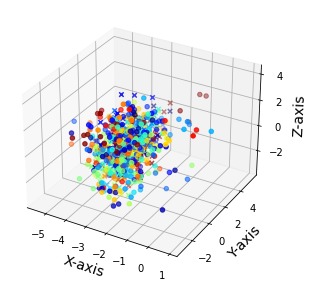

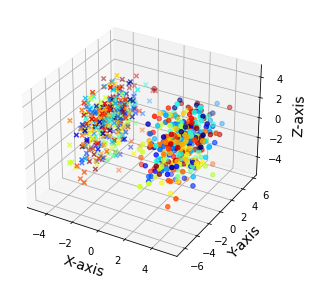

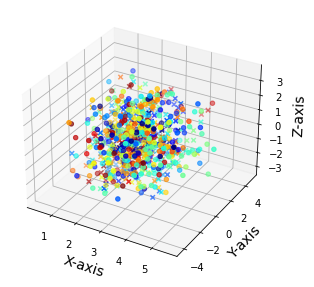

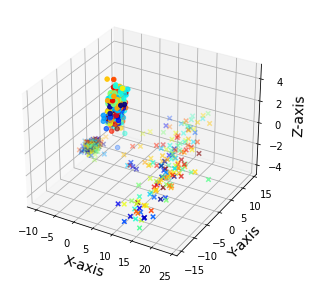

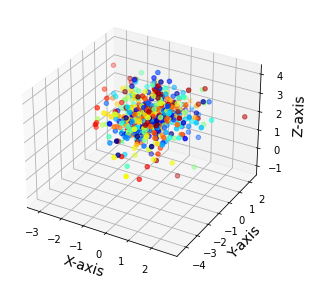

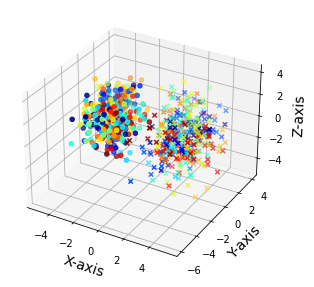

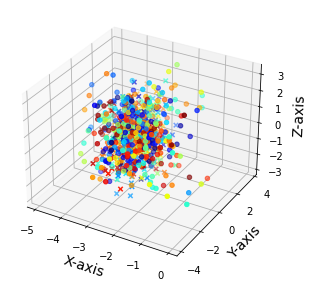

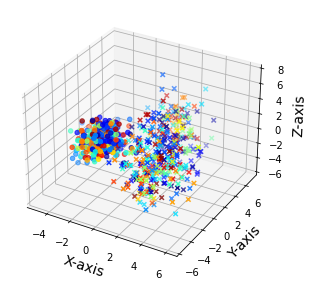

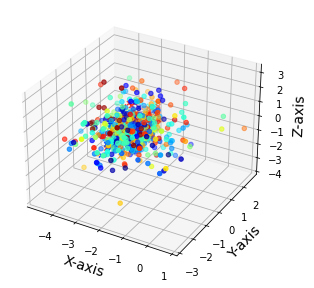

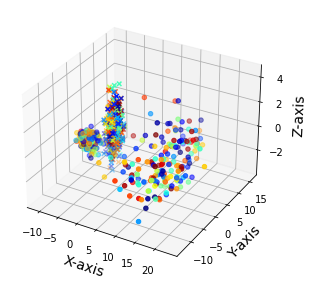

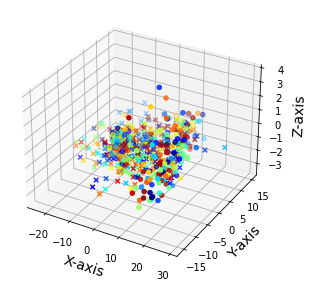

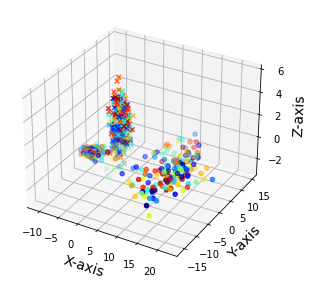

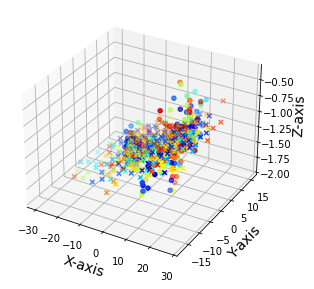

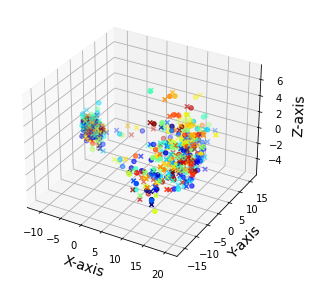

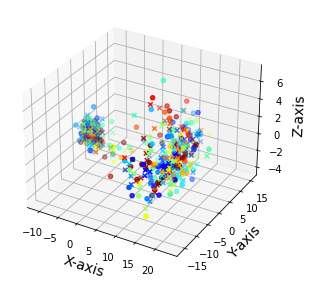

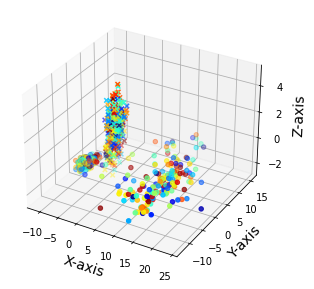

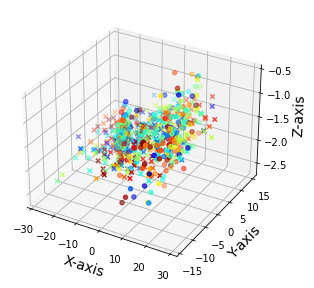

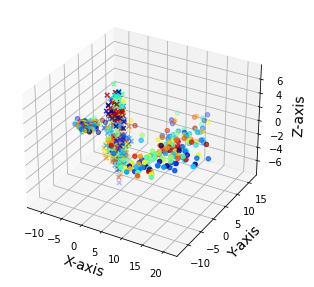

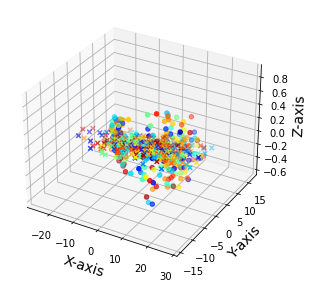

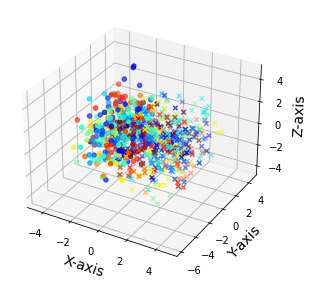

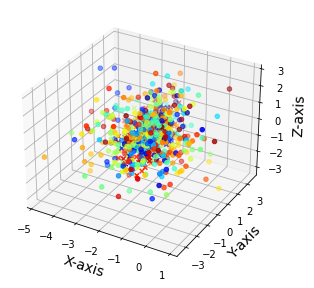

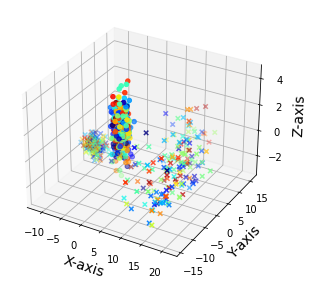

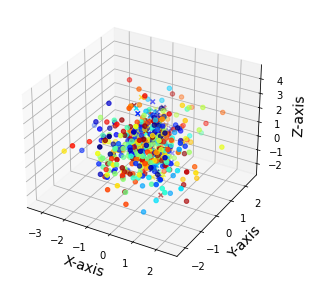

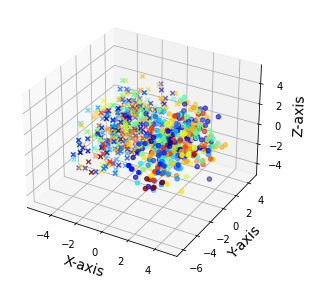

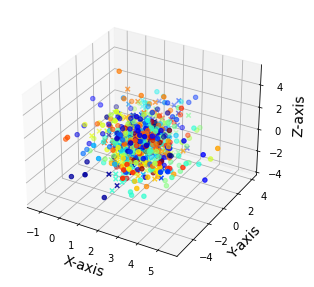

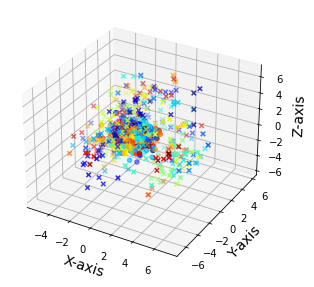

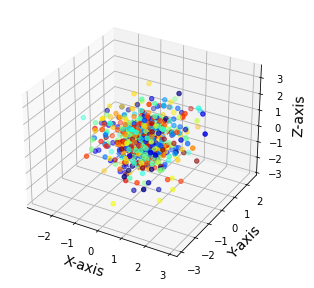

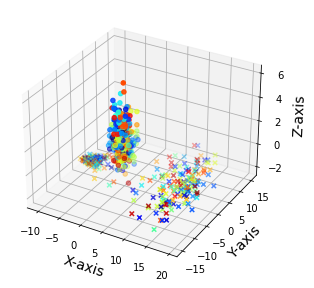

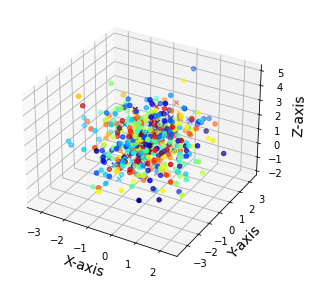

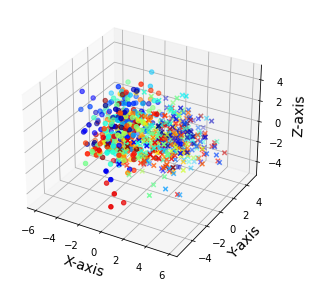

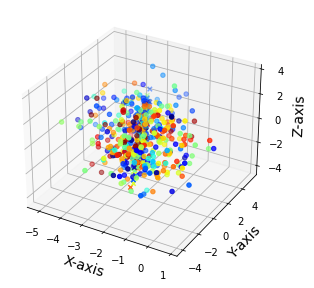

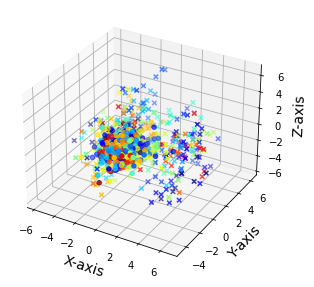

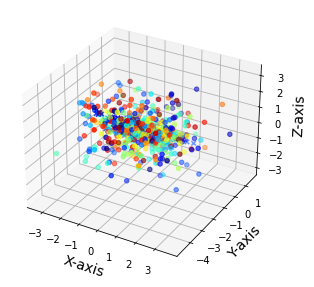

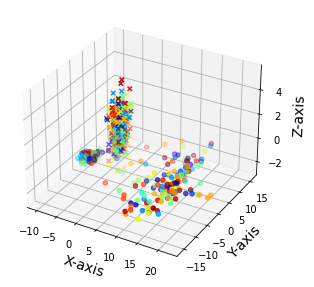

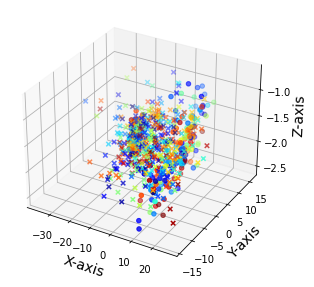

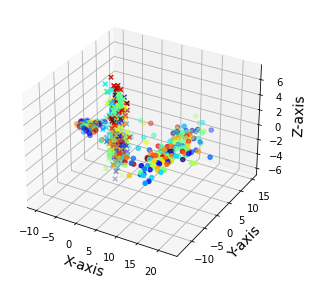

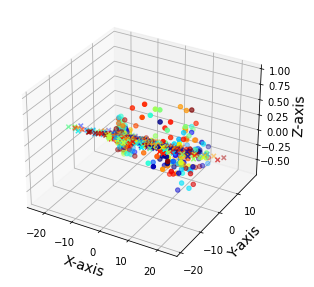

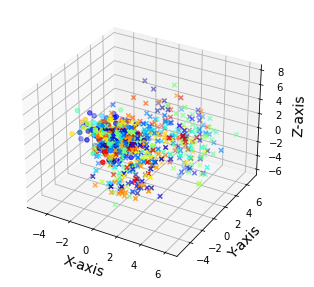

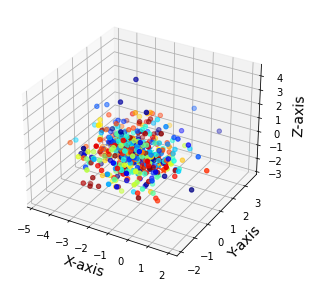

In [9]:
for model1, model2 in list(itertools.combinations(models.keys(), 2)):
    clss = models[model1]["clss"]
    plotpca_2models(model1, model2, clss, n=100)
    plotpca_2models(model1, model2, clss, n=100, fit_rotate=True)

## Embedding distances

In [10]:
from scipy.spatial.distance import cdist
from scipy.signal import convolve2d

In [19]:
def strideConv(arr, arr2, s):
    return convolve2d(arr, arr2[::-1, ::-1], mode='valid')[::s, ::s]

def plot_disthistogram(model):
    embs = models[model]["embs"]
    if "self_D" not in models[model]:
        D = cdist(embs, embs, metric='cosine')
        models[model]["self_D"] = D
    else:
        D = models[model]["self_D"]
    
    D_class = strideConv(D, np.ones((4, 4)), 4) / 16.0
    
    diag = np.diagonal(D_class).ravel()
    all_but_diag = D_class[~np.eye(D_class.shape[0],dtype=bool)].reshape(D_class.shape[0],-1).ravel()
    
    plt.hist(diag, density=True, bins=20, label="Intra-class")
    plt.hist(all_but_diag, density=True, bins=20, label="Inter-class")
    plt.ylabel('Density')
    plt.xlabel('Mean cosine distance')
#     plt.title(model)
    plt.tight_layout()
    plt.legend()
    
    plt.savefig(os.path.join(PATH_FIGURES, f"histdistance_{model}.pdf"), dpi=1000)   
    plt.show()
    
def plot_2disthistogram(model1, model2):
    embs1 = models[model1]["embs"]
    embs2 = models[model2]["embs"]
    
    D = cdist(embs1, embs2, metric='cosine')
   
    D_class = strideConv(D, np.ones((4, 4)), 4) / 16.0
    
    diag = np.diagonal(D_class).ravel()
    all_but_diag = D_class[~np.eye(D_class.shape[0],dtype=bool)].reshape(D_class.shape[0],-1).ravel()
    
    plt.hist(diag, density=True, bins=20, label="Intra-class")
    plt.hist(all_but_diag, density=True, bins=20, label="Inter-class")
    plt.ylabel('Density')
    plt.xlabel('Mean cosine distance')
#     plt.title(model)
    plt.tight_layout()
    plt.legend()
    
#     plt.savefig(os.path.join(PATH_FIGURES, f"histdistance_{model}.pdf"), dpi=1000)   
    plt.show()

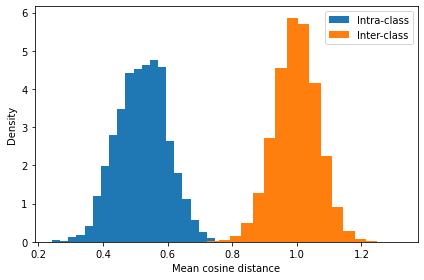

In [20]:
plot_2disthistogram('highres144_in_lowres144', 'highres32_in_lowres144')

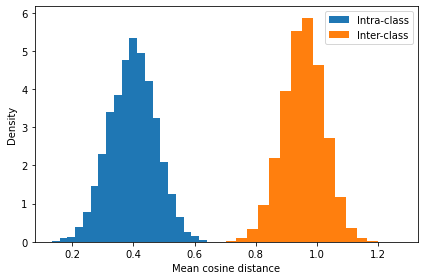

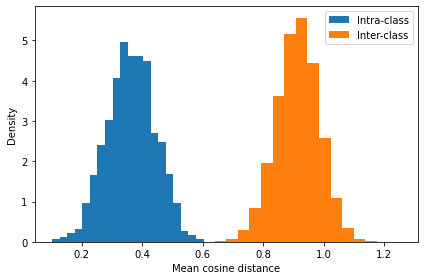

In [21]:
plot_disthistogram('highres144_in_lowres144')
plot_disthistogram('highres32_in_lowres144')

In [37]:
# plot_disthistogram('highres144_in_highlow144')
# plot_disthistogram('highres32_in_highlow144')

KeyError: 'highres32_in_highlow144'

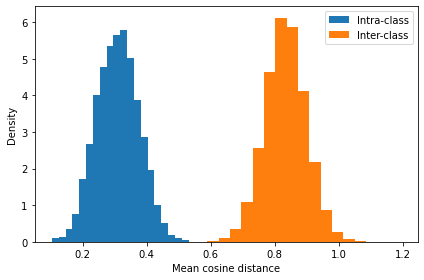

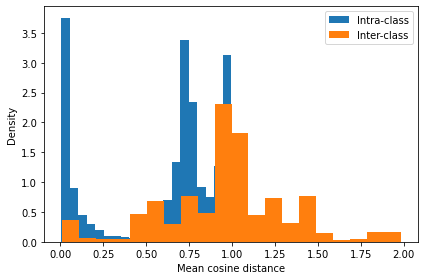

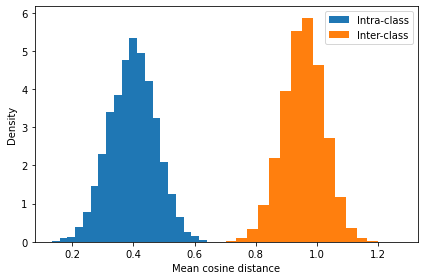

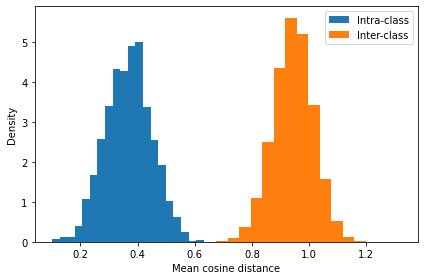

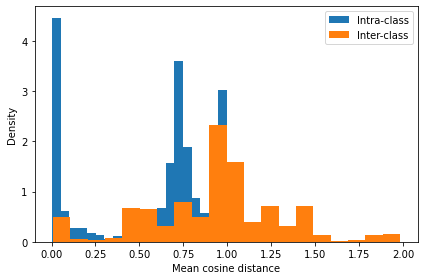

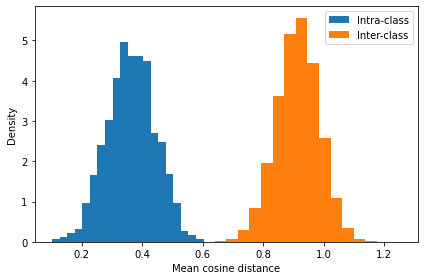

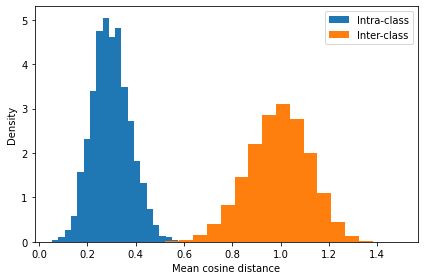

In [12]:
for model in models.keys():
    plot_disthistogram(model)

# Weight analysis

In [13]:
import sys
from pprint import pprint

In [14]:
def splitall(path):
    allparts = []
    while 1:
        parts = os.path.split(path)
        if parts[0] == path:  # sentinel for absolute paths
            allparts.insert(0, parts[0])
            break
        elif parts[1] == path: # sentinel for relative paths
            allparts.insert(0, parts[1])
            break
        else:
            path = parts[0]
            allparts.insert(0, parts[1])
    return allparts

In [15]:
checkpoints = dict()

debug_folders = glob(PATH_DEBUG+"/**/")
checknames = [splitall(folder)[-2] for folder in debug_folders]

for i, folder in enumerate(debug_folders):
    checkpoints[checknames[i]] = dict()
#     model_folder = os.path.join(folder, "model")
    backbones = [chkfile for chkfile in glob(os.path.join(folder, *["model", "*.pth"])) if "Backbone" in chkfile]
    epochs = [int(os.path.split(bfile)[1].split("Epoch_")[1].split("_")[0]) for bfile in backbones]
    checkpoints[checknames[i]]["backbone"] = backbones[np.argmax(epochs)]
    checkpoints[checknames[i]]["epoch"] = max(epochs)

In [17]:
print("Available checkpoints:")
print("\t"+"\n\t".join(checkpoints.keys()))

Available checkpoints:
	debug_finetune_lowres144_with_highres
	debug_highlow_144
	debug_highres_144
	debug_highres_32
	debug_lowres144+lowres32
	debug_lowres_144
	debug_lowres_32
	debug_modfeatures_lowres144+lowres32_with_highres
